In [1]:
"""Data Reduction Script for Highland Road Park Observatory

To use: edit the cells specifying which directories contain the calibration frames and raw data live in.
"""

'Data Reduction Script for Highland Road Park Observatory\n\nTo use: edit the cells specifying which directories contain the calibration frames and raw data live in.\n'

In [38]:
import os
import sys
import numpy as np
import ccdproc as ccdp
import astropy.units as u
import pathlib
from astropy.stats import mad_std
from astropy.coordinates import SkyCoord
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
from astropy.io import fits
import glob
import convenience_functions as cfs

User needs to specify the data directory in the below line 

In [10]:
data_dir_base = "/home/idies/workspace"                                   #THIS SHOULD BE FINE
data_dir = "Storage/tgellis/persistent/Data/20200817"                 #Right click desired night's directory, copy path, paste here.
data_dir = os.path.join(data_dir_base, data_dir)                          #This merges the two paths correctly without fail
sys.path.append(os.path.join(data_dir_base, "Storage/tgellis/persistent/hrpo-pipeline"))

In [11]:
import aperturePhot as ap

In [4]:
#Make a directory to store reduced images. Don't mix reduced images with your only clean copy of raw data!
reduced_dir = os.path.join(data_dir, "reduced")
if not os.path.exists(reduced_dir):
    os.mkdir(reduced_dir)

#Load in all of the data:
images = ccdp.ImageFileCollection(data_dir)

In [5]:
#Create master bias frame
bias_frames = images.files_filtered(imagetyp="Bias Frame", include_path=True)
if any(bias_frames):
    master_bias = ccdp.combine(bias_frames, method='median',
                               sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                               sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')
else:
    print(f"There are no bias frames in {data_dir}. Check location and path.")
    
master_bias.write(os.path.join(reduced_dir, "mbias.fit"), overwrite=True)

In [6]:
#Create master dark frame
dark_frames = images.files_filtered(imagetyp="Dark Frame", include_path=True)
reduced_darks = []
weights = []
if any(dark_frames):
    for frame in dark_frames:
        image = ccdp.CCDData.read(frame, unit='adu')
        reduced_darks.append(ccdp.subtract_bias(image, master_bias))
        weights.append(1/image.header["exptime"])
else:
    print(f"There are no dark frames in {data_dir}. Check the location and path.")
    
master_dark = ccdp.combine(reduced_darks, method='median',
                           sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu',
                          weights=np.array(weights))
master_dark.write(os.path.join(reduced_dir, "mdark.fit"), overwrite=True)

In [7]:
#Create master flat frames
filters = ['B', 'V', 'R']
master_flats = {}

for filt in filters:
    flat_frames = images.files_filtered(imagetyp="Flat Field", filter=f"Bessel {filt}", include_path=True)
    if any(flat_frames):
        reduced_flats = []
        for frame in flat_frames:
            image = ccdp.CCDData.read(frame, unit='adu')
            image = ccdp.subtract_bias(image, master_bias)
            image = ccdp.subtract_dark(image, master_dark, scale=True,
                                       exposure_unit=u.s, exposure_time='exptime')
            reduced_flats.append(image)
        
        scale = lambda x: 1/np.median(x)
        
        master_flat = ccdp.combine(reduced_flats, method='median', scale=scale,
                           sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                           sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')
        master_flat.write(os.path.join(reduced_dir, f"mflat_{filt}.fit"), overwrite=True)
        master_flats[filt] = master_flat.copy()
        
    else:
        print(f"There are no flat frames in filter Bessel {filt}.")
        

In [8]:
#Lastly we process the light frames
plate_solve = False
if plate_solve:
    ast = AstrometryNet()
    #GET YOUR API KEY
    ast.api_key = "ldzocuhpjzjpcitu"
    

In [9]:
for filt in filters:
    light_frames = images.files_filtered(imagetyp='Light Frame', filter=f"Bessel {filt}", include_path=True)
    master_flat = master_flats[filt] 
    if any(light_frames):
        for frame in light_frames:
            filename = pathlib.Path(frame).stem
            image = ccdp.CCDData.read(frame, unit='adu')
            image = ccdp.ccd_process(image, master_bias=master_bias, dark_frame=master_dark, master_flat=master_flat,
                                     dark_scale=True, exposure_unit=u.s, exposure_key='exptime')
            if plate_solve:
                try:
                    ra, dec = image.header['objctra'], image.header['objctdec']
                    wcs_header = ast.solve_from_image(frame, publicly_visible="n",
                                                      detect_threshold=4.5,
                                                      scale_lower=5, scale_upper=20, scale_units="arcminwidth",
                                                      solve_timeout=300)
                    image.header.update(wcs_header)
                    image.write(os.path.join(reduced_dir, f"{filename}_bdf_solved.fit"), overwrite=True)
                    
                except TimeoutError:
                    print(f"\nCould not solve: {frame}")
                    image.write(os.path.join(reduced_dir, f"{filename}_bdf.fit"), overwrite=True)
            
            else:
                image.write(os.path.join(reduced_dir, f"{filename}_bdf.fit"), overwrite=True)
    else:
        print(f"There are no light frames in the filter Bessel {filt}.")

# 

In [12]:
from solve_relative import solve_relative
def find_ref(image):
    solved = glob.glob(os.path.join(reduced_dir, "*solved*"))
    object_name = image.rsplit("-", 1)[0]
    reference = None
    for f in solved:
        if object_name in f:
            reference=f
    return reference

ModuleNotFoundError: No module named 'astroalign'

In [54]:
import aperturePhot as ap
f = "Storage/tgellis/persistent/Data/20200817/reduced/mdark.fit"
ccd = ccdp.CCDData.read(os.path.join(data_dir_base, f))

13.547968864440918 3.7064999999999997
0.0 32.98996677429505


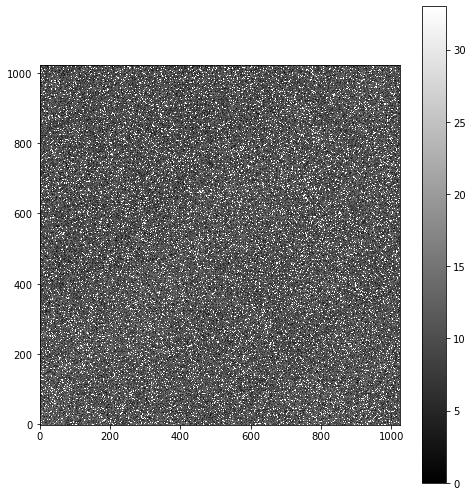

In [55]:
import matplotlib.pyplot as plt
ap.showimage(ccd, cmap="gray")

In [56]:
print(np.max(ccd.data), np.median(ccd.data), np.std(ccd.data))

7224.0 10.5 30.090919063811214


In [12]:
unsolved = glob.glob(os.path.join(reduced_dir, "*bdf.fit"))
for image in unsolved:
    basename = pathlib.Path(image).stem
    if not os.path.exists(os.path.join(reduced_dir, basename+"_solved.fit")):
        ref = find_ref(basename)
        if ref:
            new_wcs = solve_relative(image, ref)
            unsolved = fits.open(image)
            unsolved[0].header.update(new_wcs.to_header())
            unsolved.writeto(os.path.join(reduced_dir, basename+"_solved.fit"))
        else:
            print(f"There are no reference frames for {image}")
        